In [49]:
import sys
import re
sys.path.append('../')
import time
import collections
import argparse
import os
import shutil
import json
import datetime

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import numpy as np

from sklearn.metrics import jaccard_similarity_score
import warnings
warnings.filterwarnings('ignore')

## Possible Improvements

- Figure out transform for inception net
    * 
- Examine Loss function
- Visualize attention maps from different layers

In [2]:
%load_ext autoreload
%autoreload 2
# from my_optim import get_optimizer, adject_lr
import exper.my_optim as my_optim
from models import *
from utils import AverageMeter
from utils import Metrics
from utils.save_atten import SAVE_ATTEN
from utils.LoadDataAiSky import data_loader
from utils.Restore import restore

In [40]:
class dummy_val_args:
    def __init__(self):
        self.arch = "inception3_spg"
        self.batch_size = 2
        self.lr = 0.001
        self.num_classes = 2
        self.num_gpu = 1
        self.threshold = 0.6
        self.snapshot_dir = "../snapshots/pretrain_imagenet/"
        self.restore_from = "AiSky_epoch_5_glo_step_32712.pth.tar"
        self.resume = "True"
        self.tencrop = "False"

class dummy_tr_args:
    def __init__(self):
        self.arch = "inception3_spg"
        self.batch_size = 8
        self.lr = 0.001
        self.epoch = 25
        self.num_gpu = 1
        self.num_classes = 2
        self.snapshot_dir = "../snapshots/pretrain_imagenet/"
        self.restore_from = "imagenet_epoch_2_glo_step_128118.pth.tar"
        self.global_counter = 0
        self.current_epoch = 0
        self.threshold = 0.6
        self.decay_points = "none"
        self.onehot = 'False'
        self.disp_interval = 100
        self.dataset = "AiSky"
        self.resume = "True"

        

val_args = dummy_val_args()
args = dummy_tr_args()
        

In [4]:
def evaluate(args, model, loader):
    losses = AverageMeter()
    top1 = AverageMeter()
    losses.reset()
    top1.reset()

    model.eval()
    for idx, dat in enumerate(loader):
        img, label = dat
        if len(img) == 1:
            continue
        label = torch.FloatTensor([t["label"] for t in label])[:, None]

        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])
        
        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
#         if args.tencrop == 'True':
#             logits0 = logits0.view(bs, ncrops, -1).mean(1)

        # Calculate classification results
#         if args.onehot == 'True':
#             val_mAP, prob, gt = cal_mAP(logits0, label_var, prob, gt)
            # print val_mAP
#         else:
        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

    return losses.avg, top1.avg

In [5]:
def get_model(args):
    model = eval(args.arch).model(pretrained=False,
                                  num_classes=1000,
                                  threshold=args.threshold,
                                  args=args)
    model.cuda()
    model = torch.nn.DataParallel(model, range(args.num_gpu))

    optimizer = my_optim.get_finetune_optimizer(args, model)

    if args.resume == 'True':
        restore(args, model, optimizer, including_opt=False)
    return  model, optimizer

def save_checkpoint(args, state, is_best, filename='checkpoint.pth.tar'):
    savepath = os.path.join(args.snapshot_dir, filename)
    torch.save(state, savepath)
    if is_best:
        shutil.copyfile(savepath, os.path.join(args.snapshot_dir, 'model_best.pth.tar'))

In [6]:

def train(args):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model, optimizer= get_model(args)
    model.train()
    train_loader, val_loader, _ = data_loader(args)

    with open(os.path.join(args.snapshot_dir, 'train_record.csv'), 'a') as fw:
        config = json.dumps(vars(args), indent=4, separators=(',', ':'))
        fw.write(config)
        fw.write('#epoch,loss,pred@1,pred@5\n')


    total_epoch = args.epoch
    global_counter = 0 #args.global_counter
    current_epoch = 0 #args.current_epoch
    end = time.time()
    max_iter = total_epoch*len(train_loader)
    print('Max iter:', max_iter)
    while current_epoch < total_epoch:
        model.train()
        losses.reset()
        top1.reset()
        top5.reset()
        batch_time.reset()
        res = my_optim.reduce_lr(args, optimizer, current_epoch)

        if res:
            for g in optimizer.param_groups:
                out_str = 'Epoch:%d, %f\n'%(current_epoch, g['lr'])
                fw.write(out_str)

        steps_per_epoch = len(train_loader)
        for idx, dat in enumerate(train_loader):
            #img_path , img, label = dat
            img, label = dat
            label = torch.FloatTensor([t["label"] for t in label])[:, None]
            global_counter += 1
            img, label = img.cuda(), label.cuda()
            img_var, label_var = Variable(img), Variable(label)

            logits = model(img_var,  label_var)
            loss_val, _ = model.module.get_loss(logits, label_var)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if not args.onehot == 'True':
                logits1 = torch.squeeze(logits[0])
                prec1_1 = Metrics.accuracy(logits1.data, label.long(), topk=(1,))
                top1.update(prec1_1[0].item(), img.size()[0])
            losses.update(loss_val.data, img.size()[0])
            batch_time.update(time.time() - end)

            end = time.time()

            if global_counter % args.disp_interval == 0:
                # Calculate ETA
                eta_seconds = ((total_epoch - current_epoch)*steps_per_epoch + (steps_per_epoch - idx))*batch_time.avg
                eta_str = "{}".format(datetime.timedelta(seconds=int(eta_seconds)))
                eta_seconds_epoch = steps_per_epoch*batch_time.avg
                eta_str_epoch = "{}".format(datetime.timedelta(seconds=int(eta_seconds_epoch)))
                print('Epoch: [{0}][{1}/{2}] '
                      'AvgBatchTime {batch_time.avg:.3f} '
                      'ETA {eta_str}({eta_str_epoch}) '
                      'Loss {loss.val:.4f} ({loss.avg:.4f}) '
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                    current_epoch, global_counter%len(train_loader), len(train_loader), batch_time=batch_time,
                    eta_str=eta_str, eta_str_epoch = eta_str_epoch, loss=losses, top1=top1))

        print("=================================")
        print("Evaluation on val-set:")
        val_loss, val_prec_1 = evaluate(args, model, val_loader)
        print("\tEpoch %i: Val Loss: %.3f\tVal Prec@1: %.3f" % (current_epoch, val_loss, val_prec_1))
        print("=================================")
        print("")
        model.train()
                
        if current_epoch % 1 == 0:
            save_checkpoint(args,
                            {
                                'epoch': current_epoch,
                                'arch': 'resnet',
                                'global_counter': global_counter,
                                'state_dict':model.state_dict(),
                                'optimizer':optimizer.state_dict()
                            }, is_best=False,
                            filename='%s_epoch_%d_glo_step_%d.pth.tar'
                                     %(args.dataset, current_epoch,global_counter))

        with open(os.path.join(args.snapshot_dir, 'train_record.csv'), 'a') as fw:
            fw.write('%d,%.4f,%.3f,%.4f,%.3f\n'%(current_epoch, losses.avg, top1.avg, val_loss, val_prec_1))

        current_epoch += 1


In [7]:
train(args)

../models/google/inception3_spg.py:137: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


=> loading checkpoint '../snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar'
=> loaded checkpoint '../snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar' (epoch 2)
=> loaded checkpoint '../snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar'
Max iter: 136300


/usr4/cs591/shawnlin/.local/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr4/cs591/shawnlin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: [0][100/5452] AvgBatchTime 0.238 ETA 9:20:52(0:21:35) Loss 0.3976 (1.2511) Prec@1 100.000 (82.250)
Epoch: [0][200/5452] AvgBatchTime 0.237 ETA 9:19:42(0:21:33) Loss 0.4694 (0.8807) Prec@1 87.500 (86.938)
Epoch: [0][300/5452] AvgBatchTime 0.237 ETA 9:18:26(0:21:31) Loss 0.8005 (0.7468) Prec@1 87.500 (88.000)
Epoch: [0][400/5452] AvgBatchTime 0.237 ETA 9:19:19(0:21:34) Loss 0.2685 (0.6617) Prec@1 100.000 (89.188)
Epoch: [0][500/5452] AvgBatchTime 0.237 ETA 9:18:19(0:21:32) Loss 0.2165 (0.6130) Prec@1 100.000 (89.725)
Epoch: [0][600/5452] AvgBatchTime 0.237 ETA 9:17:36(0:21:32) Loss 0.7634 (0.5746) Prec@1 75.000 (90.229)
Epoch: [0][700/5452] AvgBatchTime 0.237 ETA 9:16:54(0:21:31) Loss 0.4493 (0.5409) Prec@1 87.500 (90.696)
Epoch: [0][800/5452] AvgBatchTime 0.237 ETA 9:16:22(0:21:31) Loss 0.1883 (0.5145) Prec@1 100.000 (91.062)
Epoch: [0][900/5452] AvgBatchTime 0.237 ETA 9:15:51(0:21:30) Loss 0.2861 (0.4935) Prec@1 100.000 (91.486)
Epoch: [0][1000/5452] AvgBatchTime 0.237 ETA 9:15:

Epoch: [1][2148/5452] AvgBatchTime 0.488 ETA 18:12:13(0:44:23) Loss 0.0895 (0.1803) Prec@1 100.000 (97.195)
Epoch: [1][2248/5452] AvgBatchTime 0.477 ETA 17:46:20(0:43:22) Loss 0.0814 (0.1802) Prec@1 100.000 (97.203)
Epoch: [1][2348/5452] AvgBatchTime 0.467 ETA 17:22:39(0:42:26) Loss 0.1485 (0.1802) Prec@1 100.000 (97.205)
Epoch: [1][2448/5452] AvgBatchTime 0.458 ETA 17:00:52(0:41:34) Loss 0.5755 (0.1822) Prec@1 87.500 (97.130)
Epoch: [1][2548/5452] AvgBatchTime 0.449 ETA 16:40:47(0:40:47) Loss 0.1000 (0.1813) Prec@1 100.000 (97.135)
Epoch: [1][2648/5452] AvgBatchTime 0.441 ETA 16:22:10(0:40:03) Loss 0.2973 (0.1806) Prec@1 87.500 (97.125)
Epoch: [1][2748/5452] AvgBatchTime 0.433 ETA 16:04:54(0:39:23) Loss 0.1191 (0.1810) Prec@1 100.000 (97.134)
Epoch: [1][2848/5452] AvgBatchTime 0.427 ETA 15:48:48(0:38:45) Loss 0.0801 (0.1819) Prec@1 100.000 (97.108)
Epoch: [1][2948/5452] AvgBatchTime 0.420 ETA 15:33:47(0:38:10) Loss 0.2228 (0.1818) Prec@1 87.500 (97.108)
Epoch: [1][3048/5452] AvgBatchT

Epoch: [2][4096/5452] AvgBatchTime 0.422 ETA 14:50:55(0:38:19) Loss 0.1203 (0.1538) Prec@1 100.000 (97.931)
Epoch: [2][4196/5452] AvgBatchTime 0.417 ETA 14:40:51(0:37:55) Loss 0.1028 (0.1538) Prec@1 100.000 (97.927)
Epoch: [2][4296/5452] AvgBatchTime 0.413 ETA 14:31:26(0:37:32) Loss 0.0884 (0.1544) Prec@1 100.000 (97.914)
Epoch: [2][4396/5452] AvgBatchTime 0.409 ETA 14:22:28(0:37:11) Loss 0.0866 (0.1539) Prec@1 100.000 (97.924)
Epoch: [2][4496/5452] AvgBatchTime 0.405 ETA 14:13:39(0:36:50) Loss 0.0688 (0.1538) Prec@1 100.000 (97.918)
Epoch: [2][4596/5452] AvgBatchTime 0.402 ETA 14:05:12(0:36:29) Loss 0.1248 (0.1532) Prec@1 100.000 (97.919)
Epoch: [2][4696/5452] AvgBatchTime 0.398 ETA 13:57:05(0:36:10) Loss 0.0652 (0.1525) Prec@1 100.000 (97.934)
Epoch: [2][4796/5452] AvgBatchTime 0.395 ETA 13:49:18(0:35:52) Loss 0.0683 (0.1521) Prec@1 100.000 (97.941)
Epoch: [2][4896/5452] AvgBatchTime 0.391 ETA 13:41:49(0:35:34) Loss 0.2371 (0.1517) Prec@1 87.500 (97.937)
Epoch: [2][4996/5452] AvgBatc

Epoch: [4][492/5452] AvgBatchTime 1.309 ETA 1 day, 19:26:38(1:58:58) Loss 0.0925 (0.1211) Prec@1 100.000 (98.806)
Epoch: [4][592/5452] AvgBatchTime 1.128 ETA 1 day, 13:23:58(1:42:30) Loss 0.1265 (0.1204) Prec@1 100.000 (98.733)
Epoch: [4][692/5452] AvgBatchTime 0.999 ETA 1 day, 9:06:00(1:30:47) Loss 0.0706 (0.1222) Prec@1 100.000 (98.645)
Epoch: [4][792/5452] AvgBatchTime 0.903 ETA 1 day, 5:53:07(1:22:02) Loss 0.0799 (0.1210) Prec@1 100.000 (98.706)
Epoch: [4][892/5452] AvgBatchTime 0.828 ETA 1 day, 3:23:22(1:15:15) Loss 0.0791 (0.1206) Prec@1 100.000 (98.753)
Epoch: [4][992/5452] AvgBatchTime 0.769 ETA 1 day, 1:23:44(1:09:50) Loss 0.0998 (0.1186) Prec@1 100.000 (98.803)
Epoch: [4][1092/5452] AvgBatchTime 0.720 ETA 23:45:59(1:05:24) Loss 0.0874 (0.1187) Prec@1 100.000 (98.821)
Epoch: [4][1192/5452] AvgBatchTime 0.679 ETA 22:24:32(1:01:43) Loss 0.0983 (0.1223) Prec@1 100.000 (98.742)
Epoch: [4][1292/5452] AvgBatchTime 0.645 ETA 21:15:35(0:58:36) Loss 0.0987 (0.1234) Prec@1 100.000 (98.7

Epoch: [5][2440/5452] AvgBatchTime 0.467 ETA 14:32:03(0:42:25) Loss 0.4866 (0.1122) Prec@1 87.500 (98.883)
Epoch: [5][2540/5452] AvgBatchTime 0.458 ETA 14:14:26(0:41:36) Loss 0.1840 (0.1126) Prec@1 87.500 (98.868)
Epoch: [5][2640/5452] AvgBatchTime 0.450 ETA 13:57:58(0:40:50) Loss 0.0909 (0.1135) Prec@1 100.000 (98.826)
Epoch: [5][2740/5452] AvgBatchTime 0.442 ETA 13:42:40(0:40:08) Loss 0.0781 (0.1135) Prec@1 100.000 (98.823)
Epoch: [5][2840/5452] AvgBatchTime 0.434 ETA 13:28:25(0:39:28) Loss 0.0529 (0.1136) Prec@1 100.000 (98.798)
Epoch: [5][2940/5452] AvgBatchTime 0.428 ETA 13:15:07(0:38:51) Loss 0.0570 (0.1136) Prec@1 100.000 (98.784)
Epoch: [5][3040/5452] AvgBatchTime 0.421 ETA 13:02:47(0:38:17) Loss 0.2659 (0.1135) Prec@1 87.500 (98.771)
Epoch: [5][3140/5452] AvgBatchTime 0.416 ETA 12:51:12(0:37:45) Loss 0.0630 (0.1131) Prec@1 100.000 (98.794)
Epoch: [5][3240/5452] AvgBatchTime 0.410 ETA 12:40:12(0:37:15) Loss 0.0786 (0.1128) Prec@1 100.000 (98.796)
Epoch: [5][3340/5452] AvgBatchT

KeyboardInterrupt: 

In [58]:
def val(args, model=None, current_epoch=0):
    top1 = AverageMeter()
    top5 = AverageMeter()
    losses = AverageMeter()
    top1.reset()
    top5.reset()
    losses.reset()

    if model is None:
        model, _ = get_model(args)
    model.eval()
    _, _, tst_loader = data_loader(args, test_path=True)

    save_atten = SAVE_ATTEN(save_dir='../save_bins/')

    global_counter = 0
    prob = None
    gt = None
    for idx, dat in enumerate(tst_loader):
        img, target = dat

        if idx > 50: break
        label = torch.FloatTensor([t["label"] for t in target])[:, None]

        global_counter += 1
        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])

        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

        pred_cls_label = np.argmax(logits0[:, :2].cpu().data.numpy(), axis=1)
        #print("pred_cls", pred_cls_label)

        if label[0] == 1 and pred_cls_label[0] == 1: # Only show TP cases
            
            # Calculate IOU
            for i in range(len(img)):
                target_mask = np.zeros((224, 224))
                img_cpu = img[0].cpu().permute(1,2,0)
                if idx < 50 and i == 0:
                    plt.figure(figsize=(9, 36), dpi=80)
                    plt.subplot(1,4,1)
                    plt.title("Raw Image")
                    plt.imshow(img_cpu)
                    ax = plt.gca()
                    for bbox in target[0]["bboxs"]:
                        rect = patches.Rectangle((bbox.x1, bbox.y1), bbox.w, bbox.h, linewidth=2, edgecolor='lawngreen', facecolor='none', label="%.2f"%0.0)
                        target_mask[int(bbox.y1):int(bbox.y2), int(bbox.x1):int(bbox.x2)] = 1.0
                        ax.add_patch(rect)
                    #plt.show()
                    plt.subplot(1,4,2)
                    plt.title("Heatmap")
                    plt.imshow(target_mask)
                    #plt.show()
            
            # For showing images
            if idx < 50:
                last_featmaps = model.module.get_localization_maps()
                np_last_featmaps = last_featmaps.cpu().data.numpy()
                np_last_featmaps_resize = cv2.resize(np_last_featmaps[0][1], (224, 224))

                print("heat", np_last_featmaps.shape, np_last_featmaps.max(), np_last_featmaps.min())
                plt.subplot(1,4,3)
                plt.title("Heatmap")
                plt.imshow(np_last_featmaps_resize)
                plt.subplot(1,4,4)
                seg_mask = (np_last_featmaps_resize >= 0.3).astype(np.float)
                plt.title("Image w/t SegMask")
                plt.imshow(img_cpu)
                plt.imshow(seg_mask, cmap="plasma", alpha=0.5)
                plt.show()

    print("Testing Loss: %.4f\tAcc: %.3f" % (losses.avg, top1.avg))

=> loading checkpoint '../snapshots/pretrain_imagenet/AiSky_epoch_5_glo_step_32712.pth.tar'
=> loaded checkpoint '../snapshots/pretrain_imagenet/AiSky_epoch_5_glo_step_32712.pth.tar' (epoch 5)
=> loaded checkpoint '../snapshots/pretrain_imagenet/AiSky_epoch_5_glo_step_32712.pth.tar'
heat (2, 1000, 28, 28) 1.0 0.0


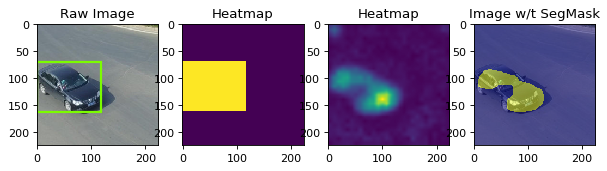

heat (2, 1000, 28, 28) 1.0 0.0


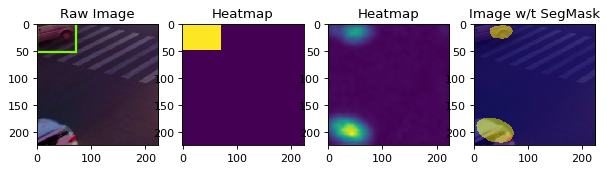

heat (2, 1000, 28, 28) 1.0 0.0


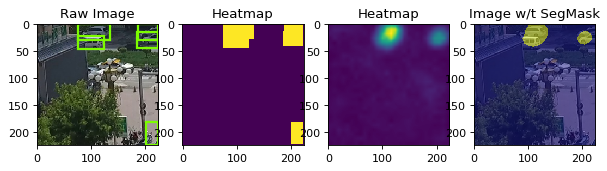

heat (2, 1000, 28, 28) 1.0 0.0


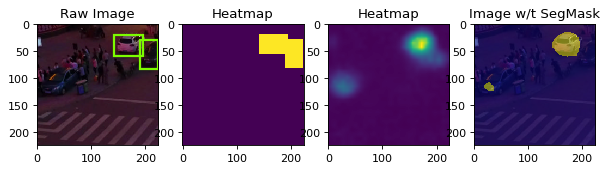

heat (2, 1000, 28, 28) 1.0 0.0


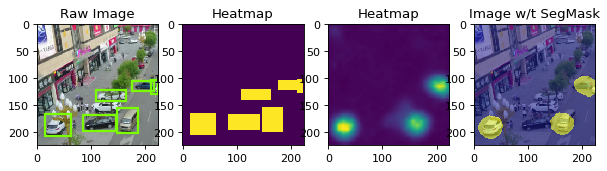

heat (2, 1000, 28, 28) 1.0 0.0


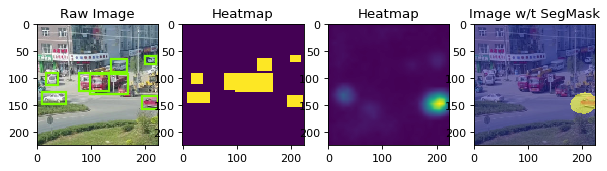

heat (2, 1000, 28, 28) 1.0 0.0


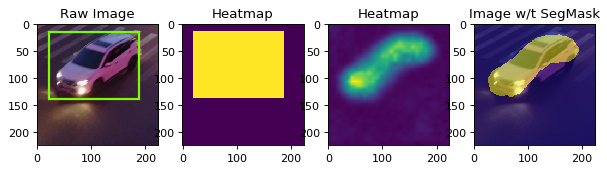

heat (2, 1000, 28, 28) 1.0 0.0


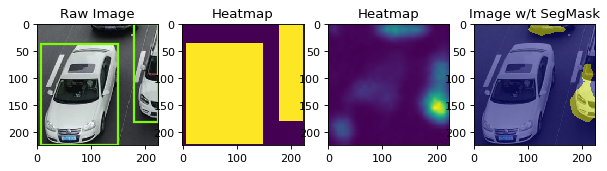

heat (2, 1000, 28, 28) 1.0 0.0


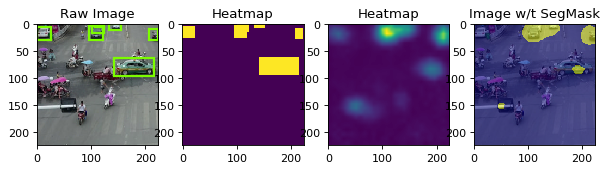

heat (2, 1000, 28, 28) 1.0 0.0


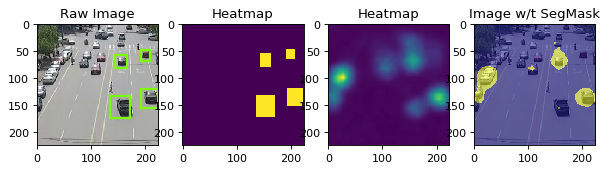

heat (2, 1000, 28, 28) 1.0 0.0


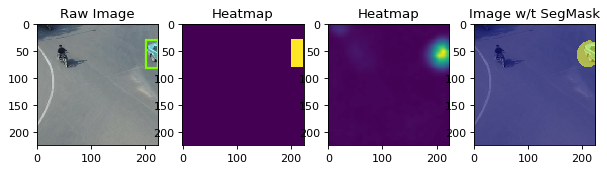

heat (2, 1000, 28, 28) 1.0 0.0


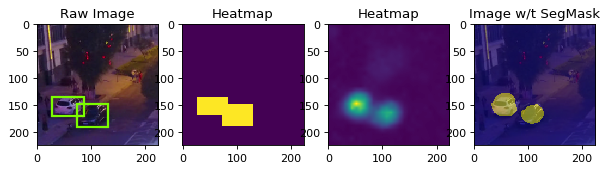

heat (2, 1000, 28, 28) 1.0 0.0


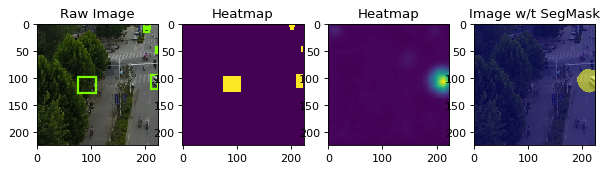

heat (2, 1000, 28, 28) 1.0 0.0


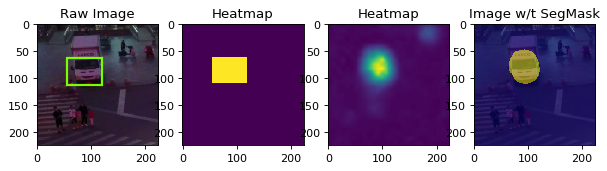

heat (2, 1000, 28, 28) 1.0 0.0


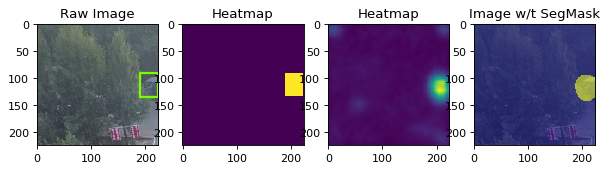

heat (2, 1000, 28, 28) 1.0 0.0


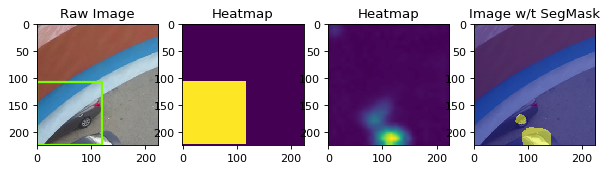

Testing Loss: 0.5592	Acc: 87.255


In [59]:
val(val_args)

In [82]:
def val_metric(args, model=None, current_epoch=0):
    top1 = AverageMeter()
    losses = AverageMeter()
    IOU_score = AverageMeter()
    top1.reset()
    losses.reset()
    IOU_score.reset()

    if model is None:
        model, _ = get_model(args)
    model.eval()
    _, _, tst_loader = data_loader(args, test_path=True)

    save_atten = SAVE_ATTEN(save_dir='../save_bins/')

    global_counter = 0
    prob = None
    gt = None
    for idx, dat in enumerate(tqdm(tst_loader)):
        img, target = dat

        label = torch.FloatTensor([t["label"] for t in target])[:, None]

        global_counter += 1
        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])

        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

        pred_cls_label = np.argmax(logits0[:, :2].cpu().data.numpy(), axis=1)
        #print("pred_cls", pred_cls_label)
        
        last_featmaps = model.module.get_localization_maps()
        np_last_featmaps = last_featmaps.cpu().data.numpy()

        for i in range(len(img)):
            if label[i] == 1 and pred_cls_label[i] == 1: # Only show TP cases

                # Calculate IOU
                target_mask = np.zeros((224, 224))
                #img_cpu = img[i].cpu().permute(1,2,0)
                for bbox in target[i]["bboxs"]:
                    target_mask[int(bbox.y1):int(bbox.y2), int(bbox.x1):int(bbox.x2)] = 1.0
                
                # attention mask
                np_last_featmaps_resize = cv2.resize(np_last_featmaps[i][1], (224, 224))
                seg_mask = (np_last_featmaps_resize >= 0.3).astype(np.float)
                iou_score = jaccard_similarity_score(seg_mask, target_mask)
                #print("IOU score:", iou_score)
                IOU_score.update(iou_score, 1)

    print("Testing Loss: %.4f\tAcc: %.3f\tIOU_score: %.3f" % (losses.avg, top1.avg, IOU_score.avg))

In [83]:
val_metric(args)

=> loading checkpoint '../snapshots/pretrain_imagenet/AiSky_epoch_5_glo_step_32712.pth.tar'
=> loaded checkpoint '../snapshots/pretrain_imagenet/AiSky_epoch_5_glo_step_32712.pth.tar' (epoch 5)
=> loaded checkpoint '../snapshots/pretrain_imagenet/AiSky_epoch_5_glo_step_32712.pth.tar'


100%|██████████| 689/689 [01:16<00:00,  8.96it/s]

Testing Loss: 0.5787	Acc: 88.298	IOU_score: 0.606
